<a href="https://colab.research.google.com/github/sefeoglu/AE_Parseval_Network/blob/master/src/notebooks/ResNet_Tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wide ResNet 16_2

In [0]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0005


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Parseval Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":
    from tensorflow.keras.utils import plot_model
    from tensorflow.keras.layers import Input
    from tensorflow.keras.models import Model

    init = (68, 100,1)

    wrn_16_2 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.0)

    wrn_16_2.summary()

   # plot_model(wrn_28_10, "WRN-16-2.png", show_shapes=True, show_layer_names=True)


conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 68, 100, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 68, 100, 16)  144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 68, 100, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 68, 100, 16)  0           batch_normalization[0][0]        
____________

In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle

import numpy as np

In [0]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()


In [99]:
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(row['crop'])
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 68, 100)

In [100]:
X = new_data_X.astype('float32')
X.shape

(5722, 68, 100)

In [0]:

img_rows, img_cols = X[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [102]:
X.shape


(5722, 68, 100, 1)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_df = pd.DataFrame(Y_data, columns=['Label'])
y_df['Encoded'] = labelencoder.fit_transform(y_df['Label'])

In [11]:
y_df['Label'].value_counts()

closed           1500
open             1500
partiallyOpen    1376
notVisible       1346
Name: Label, dtype: int64

In [12]:
y_df['Encoded'].value_counts()


2    1500
0    1500
3    1376
1    1346
Name: Encoded, dtype: int64

In [0]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_df['Encoded'])

In [0]:
from tensorflow.keras.optimizers import SGD

EPOCHS = 200
BS = 128

In [0]:
sgd = SGD(lr=0.1, momentum=0.9)

In [16]:
wrn_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")


Finished compiling


In [0]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping


In [0]:
def lr_sch(epoch):
    if epoch < 60:
        return 0.1
    elif epoch < 120:
        return 0.02
    elif epoch < 160:
        return 0.004
    else:
        return 0.0008

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [0]:
import tensorflow
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.33)

In [21]:

hist = wrn_16_2.fit_generator(generator.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   callbacks=[lr_scheduler],
                   validation_data=(X_test, y_test),
                   validation_steps=X_test.shape[0] // BS,)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
29/29 [==============================] - 17s 595ms/step - loss: 2.4586 - acc: 0.3260 - val_loss: 2.5395 - val_acc: 0.3335 - lr: 0.1000
Epoch 2/200
29/29 [==============================] - 14s 484ms/step - loss: 2.3208 - acc: 0.3765 - val_loss: 2.3468 - val_acc: 0.3806 - lr: 0.1000
Epoch 3/200
29/29 [==============================] - 14s 483ms/step - loss: 2.2335 - acc: 0.4186 - val_loss: 2.1843 - val_acc: 0.4907 - lr: 0.1000
Epoch 4/200
29/29 [==============================] - 14s 487ms/step - loss: 2.1466 - acc: 0.4475 - val_loss: 2.1042 - val_acc: 0.5034 - lr: 0.1000
Epoch 5/200
29/29 [==============================] - 14s 488ms/step - loss: 2.0594 - acc: 0.4791 - val_loss: 2.0432 - val_acc: 0.4796 - lr: 0.1000
Epoch 6/200
29/29 [==============================] - 14s 490ms/step - loss: 1.9810 - acc: 0.5077 - val_loss: 1.9313 - val_acc: 0.5135 - lr: 0.1000
Epoch 7/200
29/29 [=======================

In [0]:
wrn_16_2.save("model_wrn_last.h5")

In [24]:
img = X_train[8]
img.shape

(68, 100, 1)

In [25]:
y_train[8]

array([0., 0., 1., 0.], dtype=float32)

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


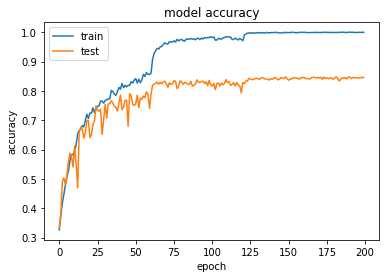

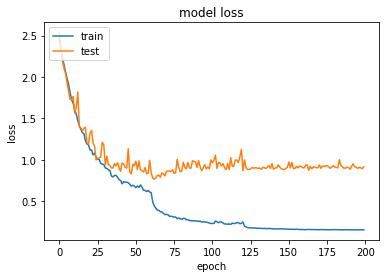

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

In [31]:
wrn_16_2.evaluate(X_test,y_test)

60/60 [==============================] - 2s 39ms/step - loss: 0.9133 - acc: 0.8470


[0.9133426547050476, 0.847009003162384]

In [32]:
wrn_16_2.evaluate(X_train,y_train)

120/120 [==============================] - 5s 38ms/step - loss: 0.1493 - acc: 1.0000


[0.14926087856292725, 1.0]

##Adversarial Examples


In [33]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 1.4MB/s 
     |████████████████████████████████| 501kB 41.4MB/s 
     |████████████████████████████████| 3.1MB 39.7MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-bzrlej2a/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-bzrlej2a/cleverhans
     |████████████████████████████████| 163kB 3.2MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262572 sha256=df319abce8690a698d93bd729bc658551a0b01bdab7596181c6eb19428f22eb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-xaxu23j9/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans

Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [0]:
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(wrn_16_2.input,wrn_16_2.layers[-1].output)

In [0]:
X_adv = []
y_adv = []
for i in range(len(X)):
  random_index = i
  original_image = X[random_index]
  original_image = tf.convert_to_tensor(original_image.reshape((1,68,100))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

  original_label = y_cat[random_index]

  epsilon = 0.4
  original_label
  adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

  adv_example_targeted_label_pred = wrn_16_2.predict(adv_example_targeted_label)
  X_adv.append(adv_example_targeted_label)
  y_adv.append(np.argmax(adv_example_targeted_label_pred))




In [0]:
y_adv = np.array(y_adv)

In [0]:

y_adv_df['Encoded'] = labelencoder.fit_transform(y_adv)

In [71]:
y_adv_df['Encoded'].value_counts()

1    2931
2    1158
0    1031
3     602
Name: Encoded, dtype: int64

In [0]:
import pickle

my_data = {'image': X_adv,
           'label': y_adv_df['Encoded']
           }
output = open('data_adv.pkl', 'wb')
pickle.dump(my_data, output)
output.close()

In [0]:
X_new = []
for i in range(len(X_adv)):
  a = np.array(X_adv[i])
  X_new.append(a.reshape(68,100,1))

In [0]:
for i in range(len(X)):
  a = np.array(X[i])
  X_new.append(a)

In [0]:
X_third = np.array(X_new)

In [127]:
X_third.shape

(11444, 68, 100, 1)

In [0]:
y_new = []
for j in range(0,2):
  for i in range(len(y_cat)):
    y_new.append(y_cat[i])
y_third = np.array(y_new)

In [0]:
X_all, y_all = X_third, y_third

In [0]:
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split( X_all,y_all, test_size = 0.33)

In [153]:
wrn_16_2_adv = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.3)

conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.


In [154]:
wrn_16_2_adv.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")
BS_adv= 100
EPOCHS_adv = 50

Finished compiling


In [0]:
def lr_sch_train(epoch):
    if epoch < 10:
        return 0.1
    elif epoch <20:
        return 0.1/2.0
    elif epoch < 30:
        return 0.1/2.0**2
    elif epoch < 40:
        return 0.1/2.0**3
    else:
        return 0.1/2.0**4

# Learning rate scheduler callback
lr_scheduler_train = LearningRateScheduler(lr_sch_train)

In [156]:

hist = wrn_16_2_adv.fit_generator(generator.flow(X_train_adv, y_train_adv, batch_size=BS_adv), steps_per_epoch=len(X_train_adv) // BS_adv, epochs=EPOCHS_adv,
                   callbacks=[lr_scheduler_train],
                   validation_data=(X_test_adv, y_test_adv),
                   validation_steps=X_test_adv.shape[0] // BS_adv,)

Epoch 1/50
76/76 [==============================] - 32s 419ms/step - loss: 2.3738 - acc: 0.3544 - val_loss: 2.2785 - val_acc: 0.4064 - lr: 0.1000
Epoch 2/50
76/76 [==============================] - 31s 411ms/step - loss: 2.1618 - acc: 0.4109 - val_loss: 2.0733 - val_acc: 0.4292 - lr: 0.1000
Epoch 3/50
76/76 [==============================] - 31s 411ms/step - loss: 1.9893 - acc: 0.4518 - val_loss: 1.9536 - val_acc: 0.4376 - lr: 0.1000
Epoch 4/50
76/76 [==============================] - 31s 413ms/step - loss: 1.8452 - acc: 0.4791 - val_loss: 1.7485 - val_acc: 0.5322 - lr: 0.1000
Epoch 5/50
76/76 [==============================] - 31s 412ms/step - loss: 1.7029 - acc: 0.5166 - val_loss: 1.6114 - val_acc: 0.5645 - lr: 0.1000
Epoch 6/50
76/76 [==============================] - 31s 413ms/step - loss: 1.5954 - acc: 0.5351 - val_loss: 1.5133 - val_acc: 0.5706 - lr: 0.1000
Epoch 7/50
76/76 [==============================] - 31s 411ms/step - loss: 1.4995 - acc: 0.5532 - val_loss: 1.4497 - val_acc

In [0]:
wrn_16_2_adv.save("model_adv_wrn_tensor_dropout.h5")

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


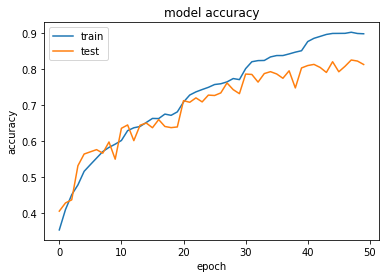

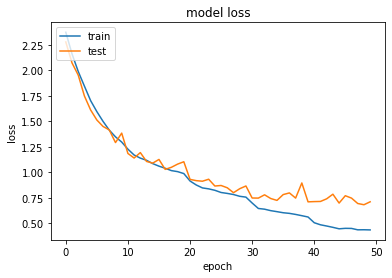

<Figure size 432x288 with 0 Axes>

In [158]:
import matplotlib.pyplot as plt

history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

**CleanExperiment**

In [159]:
wrn_16_2_clean = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.3)

conv2:channel:  -1
conv3 channel_axis:-1 
Parseval Residual Network-16-2 created.


In [160]:
wrn_16_2_clean.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

Finished compiling


In [161]:
hist_clean = wrn_16_2_clean.fit_generator(generator.flow(X_train, y_train, batch_size=BS_adv), steps_per_epoch=len(X_train) // BS_adv, epochs=EPOCHS_adv,
                   callbacks=[lr_scheduler_train],
                   validation_data=(X_test, y_test),
                   validation_steps=X_test.shape[0] // BS_adv,)

Epoch 1/50
38/38 [==============================] - 16s 420ms/step - loss: 2.4337 - acc: 0.3437 - val_loss: 2.3742 - val_acc: 0.4007 - lr: 0.1000
Epoch 2/50
38/38 [==============================] - 15s 405ms/step - loss: 2.2850 - acc: 0.3986 - val_loss: 2.2203 - val_acc: 0.4426 - lr: 0.1000
Epoch 3/50
38/38 [==============================] - 16s 410ms/step - loss: 2.1897 - acc: 0.4187 - val_loss: 2.1333 - val_acc: 0.4394 - lr: 0.1000
Epoch 4/50
38/38 [==============================] - 15s 404ms/step - loss: 2.0886 - acc: 0.4425 - val_loss: 2.0077 - val_acc: 0.4881 - lr: 0.1000
Epoch 5/50
38/38 [==============================] - 15s 403ms/step - loss: 1.9779 - acc: 0.4811 - val_loss: 2.1236 - val_acc: 0.4219 - lr: 0.1000
Epoch 6/50
38/38 [==============================] - 15s 403ms/step - loss: 1.8904 - acc: 0.5130 - val_loss: 1.7901 - val_acc: 0.5458 - lr: 0.1000
Epoch 7/50
38/38 [==============================] - 15s 403ms/step - loss: 1.7728 - acc: 0.5430 - val_loss: 1.7735 - val_acc

In [0]:
wrn_16_2_clean.save("model_adv_train_clean_dropout.h5")

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


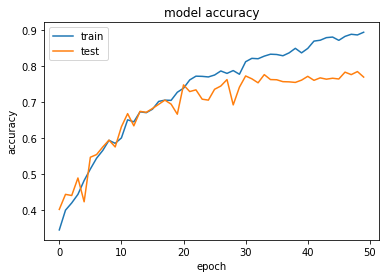

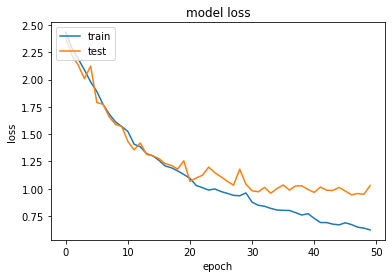

<Figure size 432x288 with 0 Axes>

In [164]:
import matplotlib.pyplot as plt

history = hist_clean
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

In [165]:
wrn_16_2_clean.evaluate(X_train, y_train)

120/120 [==============================] - 5s 38ms/step - loss: 0.6188 - acc: 0.8881


[0.6188268661499023, 0.8880771994590759]

In [166]:
wrn_16_2_adv.evaluate(X_train,y_train)

120/120 [==============================] - 4s 37ms/step - loss: 0.5650 - acc: 0.8471


[0.5650342106819153, 0.8471171259880066]

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
params = dict(epochs=[50,100,120], batch_size = [32,64,100,128])
wrn_16_2_validation = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.3)
model = KerasClassifier(build_fn=wrn_16_2_validation, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=3)
grid_result = grid.fit(X_test,y_test)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))